# Academic Paper Reference Prediction

This notebook implements a pipeline for predicting if a paper references another paper using SPECTER embeddings and XGBoost classifier.

## Structure
- **Config**: Global configuration parameters
- **DataLoader**: Classes for loading and processing data
- **FeatureEngineering**: Text processing and feature generation
- **Model**: Model definition and training
- **Pipeline**: End-to-end training process
- **Evaluation**: Model evaluation
- **Submission**: Prediction and submission file creation

## Imports

All required libraries and dependencies

In [9]:
!pip install torch torchvision torchaudio
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.0+cu124.html

Looking in links: https://data.pyg.org/whl/torch-2.5.0+cu124.html


In [10]:
# Core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from typing import Dict, List, Tuple, Optional, Union, Any
from dataclasses import dataclass
from pathlib import Path

# ML libraries
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

# PyTorch Geometric
import torch_geometric
from torch_geometric.data import Data, InMemoryDataset, Dataset
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.utils import negative_sampling, to_undirected

# Utilities
from tqdm import tqdm
import logging
import json

# Set up basic logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

## Configuration

Central configuration for all parameters

In [11]:
@dataclass
class Config:
    """Central configuration class for the project"""
    # Paths
    data_dir: str = "/kaggle/input/gammafest-celan/gammafest25"
    output_dir: str = "outputs/"
    model_dir: str = "models/"
    
    # Data files
    train_file: str = "train.csv"
    test_file: str = "test.csv"
    clean_file: str = "clean.csv"
    metadata_file: str = "papers_metadata.csv"
    
    # Preprocessing
    max_words: int = 1000  # Maximum words to keep in text fields
    
    # Embedding
    embedding_model: str = "allenai/specter"  # Pre-trained model to use
    embedding_batch_size: int = 16
    embedding_max_length: int = 512
    
    # Training
    neg_pos_ratio: int = 10  # Ratio of negative to positive samples
    test_size: float = 0.3
    random_state: int = 42
    
    # Model parameters
    xgb_params: Dict = None
    num_boost_rounds: int = 400
    early_stopping_rounds: int = 10
    prediction_threshold: float = 0.35
    
    def __post_init__(self):
        # Ensure directories exist
        os.makedirs(self.output_dir, exist_ok=True)
        os.makedirs(self.model_dir, exist_ok=True)
        
        # Define XGBoost parameters
        if self.xgb_params is None:
            self.xgb_params = {
                'objective': 'binary:logistic',
                'eval_metric': 'error',
                'subsample': 0.8,
                'eta': 0.1,
                'max_depth': 5,
                'colsample_bytree': 0.8,
                'seed': self.random_state
            }
    
    def get_path(self, file_name: str) -> str:
        """Get full path for a data file"""
        return os.path.join(self.data_dir, file_name)
    
    def get_output_path(self, file_name: str) -> str:
        """Get full path for an output file"""
        return os.path.join(self.output_dir, file_name)
    
    def get_model_path(self, file_name: str) -> str:
        """Get full path for a model file"""
        return os.path.join(self.model_dir, file_name)
    
    def save(self, file_name: str = "config.json"):
        """Save configuration to file"""
        config_dict = {k: v for k, v in self.__dict__.items() if not k.startswith('_')}
        with open(self.get_output_path(file_name), 'w') as f:
            json.dump(config_dict, f, indent=2)

# Initialize config
config = Config()
print(f"Configuration initialized with embedding model: {config.embedding_model}")

Configuration initialized with embedding model: allenai/specter


## Data Loading

Classes for loading and preprocessing the dataset

In [12]:
class DataLoader:
    """Class to handle loading and basic preprocessing of paper data"""
    
    def __init__(self, config: Config):
        """Initialize with configuration"""
        self.config = config
        self.logger = logging.getLogger(self.__class__.__name__)
    
    def load_data(self) -> Dict[str, pd.DataFrame]:
        """Load all required datasets"""
        self.logger.info("Loading datasets...")
        train_df = pd.read_csv(self.config.get_path(self.config.train_file))
        test_df = pd.read_csv(self.config.get_path(self.config.test_file))
        clean_df = pd.read_csv(self.config.get_path(self.config.clean_file))
        metadata_df = pd.read_csv(self.config.get_path(self.config.metadata_file))
        
        self.logger.info(f"Loaded train: {train_df.shape}, test: {test_df.shape}")
        return {
            'train': train_df,
            'test': test_df,
            'clean': clean_df,
            'metadata': metadata_df
        }
    
    def process_paper_data(self, data: Dict[str, pd.DataFrame]) -> pd.DataFrame:
        """Process and merge paper data"""
        self.logger.info("Processing paper data...")
        clean_df = data['clean']
        metadata_df = data['metadata']
        
        # Add paper_id to clean if not already present
        if 'paper_id' not in clean_df.columns:
            clean_df['paper_id'] = metadata_df['paper_id']
            
        # Remove duplicates
        clean_df = clean_df.drop_duplicates(subset=['paper_id'])
        metadata_df = metadata_df.drop_duplicates(subset=['paper_id'])
        
        # Merge data
        merged_df = pd.merge(clean_df, metadata_df, on='paper_id', how='inner')
        self.logger.info(f"Merged data shape: {merged_df.shape}")
        
        return merged_df
    
    def create_balanced_dataset(self, train_df: pd.DataFrame, ratio: int = None) -> pd.DataFrame:
        """Create a balanced dataset with a specified negative-to-positive ratio"""
        if ratio is None:
            ratio = self.config.neg_pos_ratio
            
        self.logger.info(f"Creating balanced dataset with {ratio}:1 negative-to-positive ratio")
        
        # Check class distribution
        label_counts = train_df['is_referenced'].value_counts()
        self.logger.info(f"Original distribution: {dict(label_counts)}")
        
        # Create balanced dataset
        positives = train_df[train_df['is_referenced'] == 1]
        negatives = train_df[train_df['is_referenced'] == 0]
        
        # Calculate sample size for negatives
        neg_sample_size = len(positives) * ratio
        neg_sample_size = min(neg_sample_size, len(negatives))  # Ensure we don't request more than available
        
        # Sample negatives
        negatives_sampled = negatives.sample(n=neg_sample_size, random_state=self.config.random_state)
        
        # Combine and shuffle
        balanced_df = pd.concat([positives, negatives_sampled])
        balanced_df = balanced_df.sample(frac=1, random_state=self.config.random_state).reset_index(drop=True)
        
        # Log new distribution
        new_counts = balanced_df['is_referenced'].value_counts()
        self.logger.info(f"Balanced distribution: {dict(new_counts)}")
        
        return balanced_df
    
    def visualize_class_distribution(self, df: pd.DataFrame, column: str = 'is_referenced'):
        """Visualize the class distribution"""
        counts = df[column].value_counts()
        percentages = counts / counts.sum() * 100
        
        # Display statistics
        print(f"Class Distribution:\n{counts}")
        print(f"\nPercentages:\n{percentages}")
        
        # Create plot
        plt.figure(figsize=(8, 6))
        counts.plot(kind='bar', color=['skyblue', 'salmon'][:len(counts)])
        plt.title(f'Distribution of {column}')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        
        # Add count labels on bars
        for i, count in enumerate(counts):
            plt.text(i, count + 0.1, f"{count} ({percentages[i]:.1f}%)", 
                     ha='center', va='bottom')
            
        plt.tight_layout()
        plt.show()

## Feature Engineering

Text processing and embedding generation

In [13]:
class TextProcessor:
    """Class for text processing operations"""
    
    def __init__(self, config: Config):
        """Initialize with configuration"""
        self.config = config
        self.logger = logging.getLogger(self.__class__.__name__)
    
    def trim_text(self, text: str, max_words: int = None) -> str:
        """Trim text to a maximum number of words"""
        if max_words is None:
            max_words = self.config.max_words
            
        if pd.isna(text):
            return ""
        return " ".join(text.split()[:max_words])
    
    def process_paper_text(self, df: pd.DataFrame) -> pd.DataFrame:
        """Process text fields in paper data"""
        self.logger.info("Processing paper text fields...")
        
        # Create a copy to avoid modifying the original
        processed_df = df.copy()
        
        # Trim lemmatized text
        if 'lemmetized' in processed_df.columns:
            processed_df['lemmetized_trimmed'] = processed_df['lemmetized'].apply(self.trim_text)
            processed_df = processed_df.drop(columns=['lemmetized'])
            
        # Convert publication_date to numeric timestamp
        if 'publication_date' in processed_df.columns:
            processed_df['publication_date'] = pd.to_datetime(
                processed_df['publication_date'], errors='coerce'
            ).astype(int) / 10**9
        
        # Create combined text input for embedding
        processed_df['text_input'] = (
            "Title: " + processed_df["title"].fillna("") + ". " +
            "Abstract: " + processed_df["lemmetized_trimmed"].fillna("") + ". " +
            "Authors: " + processed_df["authors"].fillna("") + ". " +
            "Year: " + processed_df["publication_date"].astype(str).fillna("") + "."+
            "Concepts: " + processed_df["concepts"].fillna("") + "." +
            "cited_by_count" + processed_df['cited_by_count'].astype(str).fillna("") + "."
        )
        
        return processed_df


class EmbeddingGenerator:
    """Class to generate embeddings from paper text"""
    
    def __init__(self, config: Config):
        """Initialize with configuration"""
        self.config = config
        self.logger = logging.getLogger(self.__class__.__name__)
        self._tokenizer = None
        self._model = None
        self._device = None
        
    def _load_model(self):
        """Load the embedding model and tokenizer"""
        if self._model is None or self._tokenizer is None:
            self.logger.info(f"Loading model: {self.config.embedding_model}")
            self._tokenizer = AutoTokenizer.from_pretrained(self.config.embedding_model)
            self._model = AutoModel.from_pretrained(self.config.embedding_model)
            self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            self._model.to(self._device)
            self.logger.info(f"Model loaded on {self._device}")
    
    def generate_embeddings(self, texts: List[str]) -> np.ndarray:
        """Generate embeddings for a list of texts"""
        self._load_model()
        
        self.logger.info(f"Generating embeddings for {len(texts)} texts")
        embeddings = []
        batch_size = self.config.embedding_batch_size
        
        with torch.no_grad():
            for i in tqdm(range(0, len(texts), batch_size), desc="Extracting Embeddings"):
                batch = texts[i:i + batch_size]
                encoded = self._tokenizer(
                    batch, 
                    padding=True, 
                    truncation=True, 
                    max_length=self.config.embedding_max_length, 
                    return_tensors="pt"
                )
                encoded = {key: val.to(self._device) for key, val in encoded.items()}
                
                output = self._model(**encoded)
                cls_embeddings = output.last_hidden_state[:, 0, :]  # CLS token
                embeddings.append(cls_embeddings.cpu().numpy())
        
        # Combine batches
        return np.vstack(embeddings)
    
    def create_embedding_dict(self, df: pd.DataFrame, id_col: str = 'paper_id') -> Dict[str, np.ndarray]:
        """Create a dictionary mapping paper IDs to embeddings"""
        texts = df['text_input'].fillna("").tolist()
        ids = df[id_col].tolist()
        
        embeddings = self.generate_embeddings(texts)
        embedding_dict = {paper_id: embedding for paper_id, embedding in zip(ids, embeddings)}
        
        self.logger.info(f"Created embeddings for {len(embedding_dict)} papers")
        return embedding_dict
    
    def save_embeddings(self, df: pd.DataFrame, embeddings: np.ndarray, output_file: str = 'data_with_embeddings.csv'):
        """Save embeddings with their paper IDs to a CSV file"""
        # Create a DataFrame with embeddings as columns
        embed_df = pd.DataFrame(
            embeddings, 
            columns=[f"emb_{i}" for i in range(embeddings.shape[1])]
        )
        
        # Concatenate with paper_id and text_input
        df_reset = df.reset_index(drop=True)
        df_combined = pd.concat([df_reset, embed_df], axis=1)
        
        # Save to file
        output_path = self.config.get_output_path(output_file)
        df_combined.to_csv(output_path, index=False)
        self.logger.info(f"Embeddings saved to {output_path}")
        
        return df_combined


class FeatureBuilder:
    """Class to build features for paper pairs"""
    
    def __init__(self, config: Config):
        """Initialize with configuration"""
        self.config = config
        self.logger = logging.getLogger(self.__class__.__name__)
    
    def build_pair_features(self, pairs_df: pd.DataFrame, embedding_dict: Dict[str, np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
        """Build features for paper pairs"""
        self.logger.info(f"Building pair features for {len(pairs_df)} pairs")
        
        features = []
        labels = []
        missing_ids = set()
        
        for _, row in tqdm(pairs_df.iterrows(), total=len(pairs_df), desc="Building pair features"):
            src_id = row['paper']
            tgt_id = row['referenced_paper']
            label = row.get('is_referenced', -1)  # Default to -1 for test data
            
            # Skip if either paper is not in the embedding dictionary
            if src_id not in embedding_dict or tgt_id not in embedding_dict:
                missing_ids.update([src_id, tgt_id])
                continue
            
            # Get embeddings
            src_vec = embedding_dict[src_id]
            tgt_vec = embedding_dict[tgt_id]
            
            # Calculate cosine similarity
            sim = cosine_similarity([src_vec], [tgt_vec])[0][0]
            
            # Combine features: [source_embedding, target_embedding, similarity]
            combined = np.concatenate([src_vec, tgt_vec, [sim]])
            
            features.append(combined)
            labels.append(label)
        
        if missing_ids:
            self.logger.warning(f"Skipped {len(missing_ids)} paper_id(s) that had no embeddings")
            
        return np.array(features), np.array(labels)
    
    def build_test_features(self, test_df: pd.DataFrame, embedding_dict: Dict[str, np.ndarray]) -> Tuple[np.ndarray, List[Tuple[str, str]]]:
        """Build features for test paper pairs and keep track of paper IDs"""
        self.logger.info(f"Building test features for {len(test_df)} pairs")
        
        features = []
        test_ids = []
        
        for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Building test features"):
            src_id = row['paper']
            tgt_id = row['referenced_paper']
            
            # Skip if either paper is not in the embedding dictionary
            if src_id not in embedding_dict or tgt_id not in embedding_dict:
                continue
            
            # Get embeddings
            src_vec = embedding_dict[src_id]
            tgt_vec = embedding_dict[tgt_id]
            
            # Calculate cosine similarity
            sim = cosine_similarity([src_vec], [tgt_vec])[0][0]
            
            # Combine features
            combined = np.concatenate([src_vec, tgt_vec, [sim]])
            
            features.append(combined)
            test_ids.append((src_id, tgt_id))
            
        return np.array(features), test_ids

In [48]:
class PaperReferenceGraphDataset(InMemoryDataset):
    """
    PyTorch Geometric dataset for paper reference prediction. Creates a graph where:
    - Nodes: Research papers
    - Edges: Citation relationships (directed from citing to cited paper)
    - Node features: Paper metadata and text embeddings
    - Edge labels: 1 (reference) or 0 (no reference)
    """
    
    def __init__(self, 
                 root: str='outputs/',
                 name: str = 'gammafest25',
                 train: bool = True,
                 transform = None,
                 pre_transform = None,
                 pre_filter = None):
        """
        Initialize the dataset.
        
        Args:
            root: Root directory where the dataset should be saved
            name: Dataset name
            train: If True, load the training dataset, otherwise load the test dataset
            transform: Function/transform that takes in a Data object and returns a transformed version
            pre_transform: Function/transform that takes in a Data object and returns a transformed version
                           (applied before the dataset is saved to disk)
            pre_filter: Function that takes in a Data object and returns a boolean value
                        (whether the data object should be included)
        """
        self.name = name
        self.train = train
        self.logger = logging.getLogger(self.__class__.__name__)
        
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data = torch.load(self.processed_paths[0] if train else self.processed_paths[1])
    
    @property
    def raw_dir(self) -> str:
        """Get the raw directory path"""
        return os.path.join(self.root, self.name)
    
    @property
    def raw_file_names(self) -> List[str]:
        """List of raw file names"""
        return ['train.csv', 'test.csv', 'papers_metadata.csv', 'clean.csv']
    
    @property
    def processed_dir(self) -> str:
        """Get the processed directory path"""
        return os.path.join("outputs/", 'processed')
    
    @property
    def processed_file_names(self) -> List[str]:
        """List of processed file names"""
        return ['train_data.pt', 'test_data.pt']
   
    def process(self):
        """Process the raw data and create graph data objects"""
        self.logger.info("Processing raw data to create graph dataset...")
        data_dir ="/kaggle/input/gammafest-celan/gammafest25"
        # Load raw data
        train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
        test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))
        metadata_df = pd.read_csv(os.path.join(data_dir, 'papers_metadata.csv'))
        clean_df = pd.read_csv(os.path.join(data_dir, 'clean.csv'))
        
        self.logger.info(f"Loaded data: {len(train_df)} train pairs, {len(test_df)} test pairs, "
                        f"{len(metadata_df)} papers with metadata")
        
        # Process metadata to create node features
        node_features, paper_id_to_idx = self._process_node_features(metadata_df, clean_df)
        
        # Create training graph
        train_data = self._create_graph_data(train_df, node_features, paper_id_to_idx)
        if self.pre_transform is not None:
            train_data = self.pre_transform(train_data)
        torch.save(self.collate([train_data]), self.processed_paths[0])
        
        # Create test graph
        test_data = self._create_graph_data(test_df, node_features, paper_id_to_idx, is_train=False)
        if self.pre_transform is not None:
            test_data = self.pre_transform(test_data)
        torch.save(self.collate([test_data]), self.processed_paths[1])
        
        self.logger.info("Graph dataset processing completed successfully")
    
    def _process_node_features(self, metadata_df: pd.DataFrame, clean_df: pd.DataFrame) -> Tuple[torch.Tensor, dict]:
        """Process paper metadata to create node features"""
        self.logger.info("Processing node features from metadata")
        
        # Create a mapping from paper_id to node index
        unique_papers = sorted(set(metadata_df['paper_id'].unique()))
        paper_id_to_idx = {paper_id: idx for idx, paper_id in enumerate(unique_papers)}
        
        # Extract and normalize features
        num_nodes = len(unique_papers)
        
        # Initialize feature matrix with default features
        # We'll use basic features + text embeddings later
        feature_dim = 10  # Can be expanded when we add embeddings
        features = torch.zeros((num_nodes, feature_dim), dtype=torch.float)
        
        # Process each paper's metadata and add features
        for _, row in metadata_df.iterrows():
            paper_id = row['paper_id']
            if paper_id not in paper_id_to_idx:
                continue
                
            idx = paper_id_to_idx[paper_id]
            
            # 1. Normalized publication year
            try:
                pub_year = float(row['publication_year'])
                norm_year = (pub_year - 2010) / 10  # Simple normalization
                features[idx, 0] = norm_year
            except (ValueError, TypeError):
                features[idx, 0] = 0.0
            
            # 2. Log-normalized citation count
            try:
                cited_count = float(row['cited_by_count'])
                features[idx, 1] = np.log1p(cited_count) / 10  # Log transform to handle skew
            except (ValueError, TypeError):
                features[idx, 1] = 0.0
            
            # 3. Publication type (one-hot)
            pub_type = str(row['type']).lower() if not pd.isna(row['type']) else ''
            if 'article' in pub_type:
                features[idx, 2] = 1.0
            elif 'review' in pub_type:
                features[idx, 3] = 1.0
            elif 'preprint' in pub_type:
                features[idx, 4] = 1.0
        
        self.logger.info(f"Created node features of shape {features.shape}")
        return features, paper_id_to_idx
    
    def _create_graph_data(self, pairs_df: pd.DataFrame, node_features: torch.Tensor, 
                          paper_id_to_idx: dict, is_train: bool = True) -> Data:
        """Create a PyG Data object from the paper pairs"""
        # Prepare edge information
        edge_index = []
        edge_attr = []
        
        skipped_edges = 0
        for _, row in pairs_df.iterrows():
            source_id = row['paper']
            target_id = row['referenced_paper']
            
            # Skip if either paper is not in the mapping
            if source_id not in paper_id_to_idx or target_id not in paper_id_to_idx:
                skipped_edges += 1
                continue
            
            # Get node indices
            source_idx = paper_id_to_idx[source_id]
            target_idx = paper_id_to_idx[target_id]
            
            # Add edge (source -> target)
            edge_index.append([source_idx, target_idx])
            
            # Add edge label if available (for training)
            if 'is_referenced' in row:
                edge_attr.append([float(row['is_referenced'])])
        
        # Convert to tensors
        if edge_index:
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            
            # Create edge attributes if available
            edge_attr = torch.tensor(edge_attr, dtype=torch.float) if edge_attr else None
        else:
            # Handle case with no valid edges
            edge_index = torch.zeros((2, 0), dtype=torch.long)
            edge_attr = None
        
        # Create the Data object
        data = Data(
            x=node_features,
            edge_index=edge_index,
            edge_attr=edge_attr,
            num_nodes=node_features.size(0)
        )
        
        self.logger.info(
            f"Created {'training' if is_train else 'test'} graph with "
            f"{data.num_nodes} nodes and {data.num_edges} edges. "
            f"Skipped {skipped_edges} edges due to missing papers."
        )
        
        return data


class PaperReferenceDataLoader:
    """
    Utility class for loading and processing the paper reference dataset using PyTorch Geometric.
    """
    
    def __init__(self, config: Config):
        """
        Initialize the data loader.
        
        Args:
            config: Configuration object with dataset parameters
        """
        self.config = config
        self.logger = logging.getLogger(self.__class__.__name__)
        self.train_dataset = None
        self.test_dataset = None
        self.paper_id_map = {}  # Mapping from paper_id to node index
        
        # Create processed directory if it doesn't exist
        os.makedirs(os.path.join(self.config.output_dir, 'processed'), exist_ok=True)
    
    def load_datasets(self) -> Tuple[PaperReferenceGraphDataset, PaperReferenceGraphDataset]:
        """Load the training and testing datasets"""
        self.logger.info("Loading PyTorch Geometric datasets...")
        
        # Load or process training dataset
        self.train_dataset = PaperReferenceGraphDataset(
            root=self.config.data_dir,
            train=True
        )
        
        # Load or process test dataset
        self.test_dataset = PaperReferenceGraphDataset(
            root=self.config.data_dir,
            train=False
        )
        
        self.logger.info(f"Successfully loaded PyG datasets: "
                       f"Training nodes={self.train_dataset.data.num_nodes}, "
                       f"edges={self.train_dataset.data.num_edges}; "
                       f"Test edges={self.test_dataset.data.num_edges}")
        
        return self.train_dataset, self.test_dataset
    
    def create_dataloader(self, dataset, batch_size=1, shuffle=True):
        """Create a DataLoader for a given dataset"""
        return PyGDataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    def enhance_node_features_with_embeddings(self, embedding_dict=None, embedding_file=None, paper_id_column='paper_id'):
        """
        Enhance node features with pre-computed text embeddings
        
        Args:
            embedding_dict: Dictionary mapping paper_id to embedding vector
            embedding_file: Path to file with pre-computed embeddings (alternative to embedding_dict)
            paper_id_column: Name of the column containing the paper_id in the embedding file
        
        Returns:
            Updated datasets with enhanced node features
        """
        self.logger.info("Enhancing node features with text embeddings")
        
        if self.train_dataset is None or self.test_dataset is None:
            self.logger.warning("No datasets loaded yet. Loading datasets first.")
            self.load_datasets()
        
        # Load embeddings from file if not provided directly
        if embedding_dict is None and embedding_file is not None:
            self.logger.info(f"Loading embeddings from {embedding_file}")
            try:
                embedding_df = pd.read_csv(embedding_file)
                embedding_columns = [col for col in embedding_df.columns if col.startswith('emb_')]
                
                if not embedding_columns:
                    raise ValueError(f"No embedding columns found in {embedding_file}")
                
                embedding_dict = {
                    row[paper_id_column]: row[embedding_columns].values.astype(float)
                    for _, row in embedding_df.iterrows()
                }
                self.logger.info(f"Loaded embeddings for {len(embedding_dict)} papers")
            except Exception as e:
                self.logger.error(f"Error loading embeddings: {e}")
                raise
        elif embedding_dict is None:
            raise ValueError("Either embedding_dict or embedding_file must be provided")
        
        # Function to update features for a dataset
        def update_dataset_features(dataset, embedding_dim=768):
            # Get the original data
            data = dataset.data
            
            # Get the mapping from paper_id to node index (stored during dataset creation)
            paper_id_map = {}
            
            # Load papers_metadata to reconstruct paper_id to node index mapping
            metadata_df = pd.read_csv("/kaggle/input/gammafest-celan/gammafest25/papers_metadata.csv")
            unique_papers = sorted(set(metadata_df['paper_id'].unique()))
            paper_id_map = {paper_id: idx for idx, paper_id in enumerate(unique_papers)}
            
            # Number of original features
            orig_features = data.x.shape[1] if hasattr(data, 'x') else 0
            
            # Create new feature matrix with original + embedding features
            num_nodes = data.num_nodes
            new_features = torch.zeros((num_nodes, orig_features + embedding_dim), dtype=torch.float)
            
            # Copy original features if they exist
            if orig_features > 0:
                new_features[:, :orig_features] = data.x
            
            # Add embeddings
            embedding_count = 0
            for paper_id, idx in paper_id_map.items():
                if paper_id in embedding_dict:
                    embedding = embedding_dict[paper_id]
                    # Ensure embedding has the expected shape
                    if len(embedding) == embedding_dim:
                        new_features[idx, orig_features:] = torch.tensor(embedding, dtype=torch.float)
                        embedding_count += 1
            
            # Update the feature matrix
            data.x = new_features
            
            self.logger.info(
                f"Enhanced features for {embedding_count}/{num_nodes} nodes. "
                f"New feature dimension: {new_features.shape[1]}"
            )
            
            # You need to save the updated data as PyG expects it
            return dataset
        
        # Update both train and test datasets
        embedding_dim = len(next(iter(embedding_dict.values()))) if embedding_dict else 768
        self.logger.info(f"Using embedding dimension: {embedding_dim}")
        
        # Update datasets
        self.train_dataset = update_dataset_features(self.train_dataset, embedding_dim)
        self.test_dataset = update_dataset_features(self.test_dataset, embedding_dim)
        
        # Store updated datasets to files
        torch.save(self.train_dataset.data, self.train_dataset.processed_paths[0])
        torch.save(self.test_dataset.data, self.test_dataset.processed_paths[1])
        
        self.logger.info("Node features enhancement completed successfully")
        
        return self.train_dataset, self.test_dataset
    
    def generate_and_enhance_with_embeddings(self, text_processor=None, embedding_generator=None):
        """
        Generate embeddings from paper text and enhance node features in one step.
        This is a convenience method that combines text processing, embedding generation,
        and node feature enhancement.
        
        Args:
            text_processor: TextProcessor instance for processing paper text
            embedding_generator: EmbeddingGenerator instance for generating embeddings
            
        Returns:
            Updated datasets with enhanced node features
        """
        self.logger.info("Generating embeddings and enhancing node features")
        
        # Check if dependencies are provided
        if text_processor is None or embedding_generator is None:
            self.logger.info("Creating text processor and embedding generator")
            text_processor = TextProcessor(self.config)
            embedding_generator = EmbeddingGenerator(self.config)
        
        # 1. Load paper data
        self.logger.info("Loading paper data")
        data_loader = DataLoader(self.config)
        data = data_loader.load_data()
        paper_data = data_loader.process_paper_data(data)
        
        # 2. Process text
        self.logger.info("Processing paper text")
        processed_data = text_processor.process_paper_text(paper_data)
        
        # 3. Generate embeddings
        self.logger.info("Generating embeddings")
        paper_subset = processed_data[['paper_id', 'text_input']]
        texts = paper_subset['text_input'].fillna("").tolist()
        embeddings = embedding_generator.generate_embeddings(texts)
        
        # 4. Create embedding dictionary
        self.logger.info("Creating embedding dictionary")
        embedding_dict = {
            paper_id: embedding
            for paper_id, embedding in zip(paper_subset['paper_id'], embeddings)
        }
        
        # 5. Enhance node features
        self.logger.info("Enhancing node features with generated embeddings")
        self.enhance_node_features_with_embeddings(embedding_dict=embedding_dict)
        
        return self.train_dataset, self.test_dataset
        
    def clean_temp_files(self):
        """Clean temporary files created during dataset processing"""
        # Optional method to remove temporary files if needed
        pass

## Model Definition

XGBoost model implementation

In [17]:
class XGBoostModel:
    """Class for training and using XGBoost models"""
    
    def __init__(self, config: Config):
        """Initialize with configuration"""
        self.config = config
        self.logger = logging.getLogger(self.__class__.__name__)
        self.model = None
        self.feature_importance = None
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray = None, y_val: np.ndarray = None) -> xgb.Booster:
        """Train XGBoost model"""
        self.logger.info("Training XGBoost model")
        
        # Create DMatrix objects
        dtrain = xgb.DMatrix(X_train, label=y_train)
        eval_list = [(dtrain, 'train')]
        
        if X_val is not None and y_val is not None:
            dval = xgb.DMatrix(X_val, label=y_val)
            eval_list.append((dval, 'val'))
        
        # Track evaluation metrics
        evals_result = {}
        
        # Train the model
        self.model = xgb.train(
            params=self.config.xgb_params,
            dtrain=dtrain,
            num_boost_round=self.config.num_boost_rounds,
            evals=eval_list,
            early_stopping_rounds=self.config.early_stopping_rounds,
            evals_result=evals_result,
            verbose_eval=50
        )
        
        # Store feature importance
        self.feature_importance = self.model.get_score(importance_type='gain')
        
        # Plot training progress
        self.plot_training_progress(evals_result)
        
        return self.model
    
    def predict(self, X: np.ndarray, threshold: float = None) -> Tuple[np.ndarray, np.ndarray]:
        """Generate predictions using the trained model"""
        if self.model is None:
            raise ValueError("Model not trained yet. Call train() first.")
            
        if threshold is None:
            threshold = self.config.prediction_threshold
            
        # Create DMatrix for predictions
        dmatrix = xgb.DMatrix(X)
        
        # Get probability predictions
        y_prob = self.model.predict(dmatrix)
        
        # Apply threshold for binary classification
        y_pred = (y_prob > threshold).astype(int)
        
        return y_prob, y_pred
    
    def save_model(self, file_name: str = 'xgboost_model.json'):
        """Save the trained model"""
        if self.model is None:
            raise ValueError("Model not trained yet. Call train() first.")
            
        model_path = self.config.get_model_path(file_name)
        self.model.save_model(model_path)
        self.logger.info(f"Model saved to {model_path}")
    
    def load_model(self, file_name: str = 'xgboost_model.json'):
        """Load a trained model"""
        model_path = self.config.get_model_path(file_name)
        
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found at {model_path}")
            
        self.model = xgb.Booster()
        self.model.load_model(model_path)
        self.logger.info(f"Model loaded from {model_path}")
        
        return self.model
    
    def plot_training_progress(self, evals_result: Dict):
        """Plot the training progress"""
        if not evals_result or 'train' not in evals_result:
            self.logger.warning("No evaluation results available for plotting")
            return
            
        # Get the evaluation metric (should be 'error')
        metric = list(evals_result['train'].keys())[0]
        
        plt.figure(figsize=(10, 6))
        
        # Plot training error
        plt.plot(evals_result['train'][metric], label='Train')
        
        # Plot validation error if available
        if 'val' in evals_result:
            plt.plot(evals_result['val'][metric], label='Validation')
            
        plt.xlabel('Iteration')
        plt.ylabel(f'{metric.capitalize()}')
        plt.title(f'{metric.capitalize()} vs Iteration')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
    def tune_threshold(self, X_val: np.ndarray, y_val: np.ndarray):
        """Find the optimal threshold for binary classification"""
        if self.model is None:
            raise ValueError("Model not trained yet. Call train() first.")
            
        # Get probability predictions
        dval = xgb.DMatrix(X_val)
        y_prob = self.model.predict(dval)
        
        # Try different thresholds
        thresholds = np.arange(0.1, 0.9, 0.05)
        results = []
        
        for threshold in thresholds:
            y_pred = (y_prob > threshold).astype(int)
            mcc = matthews_corrcoef(y_val, y_pred)
            results.append((threshold, mcc))
            print(f"Threshold: {threshold:.2f} - MCC Score: {mcc:.4f}")
            
        # Find best threshold
        best_threshold, best_score = max(results, key=lambda x: x[1])
        print(f"\nBest threshold: {best_threshold:.2f} with MCC Score: {best_score:.4f}")
        
        return best_threshold

## Model Evaluation

Evaluate model performance

In [18]:
class ModelEvaluator:
    """Class for evaluating model performance"""
    
    def __init__(self, config: Config):
        """Initialize with configuration"""
        self.config = config
        self.logger = logging.getLogger(self.__class__.__name__)
        
    def evaluate(self, y_true: np.ndarray, y_pred: np.ndarray):
        """Evaluate model performance"""
        self.logger.info("Evaluating model performance")
        
        # Calculate metrics
        conf_matrix = confusion_matrix(y_true, y_pred)
        class_report = classification_report(y_true, y_pred)
        mcc = matthews_corrcoef(y_true, y_pred)
        
        # Print results
        print("Confusion Matrix:")
        print(conf_matrix)
        print("\nClassification Report:")
        print(class_report)
        print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
        
        # Plot confusion matrix
        self.plot_confusion_matrix(conf_matrix)
        
        return {
            'confusion_matrix': conf_matrix,
            'classification_report': class_report,
            'mcc': mcc
        }
    
    def plot_confusion_matrix(self, conf_matrix: np.ndarray):
        """Plot confusion matrix"""
        plt.figure(figsize=(8, 6))
        plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        
        # Add labels
        classes = ['0', '1']
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)
        
        # Add text annotations
        thresh = conf_matrix.max() / 2
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                plt.text(j, i, format(conf_matrix[i, j], 'd'),
                         ha="center", va="center",
                         color="white" if conf_matrix[i, j] > thresh else "black")
                
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

## Submission Generator

Create submission files for competition

In [19]:
class SubmissionGenerator:
    """Class for generating submission files"""
    
    def __init__(self, config: Config):
        """Initialize with configuration"""
        self.config = config
        self.logger = logging.getLogger(self.__class__.__name__)
        
    def create_submission(self, test_ids: List[Tuple[str, str]], predictions: np.ndarray, file_name: str = 'submission.csv'):
        """Create a submission file"""
        self.logger.info(f"Creating submission with {len(predictions)} predictions")
        
        # Create DataFrame
        submission_df = pd.DataFrame({
            'id': range(len(test_ids)),
            'paper': [id_pair[0] for id_pair in test_ids],
            'referenced_paper': [id_pair[1] for id_pair in test_ids],
            'is_referenced': predictions
        })
        
        # Select and rename columns for submission format
        submission_df = submission_df[['id', 'is_referenced']]
        
        # Save to file
        output_path = self.config.get_output_path(file_name)
        submission_df.to_csv(output_path, index=False)
        self.logger.info(f"Submission saved to {output_path}")
        
        return submission_df

## Pipeline

End-to-end pipeline for training and prediction

In [20]:
class Pipeline:
    """End-to-end pipeline for paper reference prediction"""
    
    def __init__(self, config: Config = None):
        """Initialize the pipeline"""
        self.config = config or Config()
        self.logger = logging.getLogger(self.__class__.__name__)
        
        # Initialize components
        self.data_loader = DataLoader(self.config)
        self.text_processor = TextProcessor(self.config)
        self.embedding_generator = EmbeddingGenerator(self.config)
        self.feature_builder = FeatureBuilder(self.config)
        self.model = XGBoostModel(self.config)
        self.evaluator = ModelEvaluator(self.config)
        self.submission_generator = SubmissionGenerator(self.config)
    
    def train_pipeline(self):
        """Run the training pipeline"""
        self.logger.info("Running training pipeline")
        
        # 1. Load data
        data = self.data_loader.load_data()
        
        # 2. Process paper data
        paper_data = self.data_loader.process_paper_data(data)
        
        # 3. Process text
        processed_data = self.text_processor.process_paper_text(paper_data)
        
        # 4. Generate embeddings
        paper_subset = processed_data[['paper_id', 'text_input']]
        texts = paper_subset['text_input'].fillna("").tolist()
        embeddings = self.embedding_generator.generate_embeddings(texts)
        
        # 5. Save embeddings
        embedding_df = self.embedding_generator.save_embeddings(paper_subset, embeddings)
        
        # 6. Create embedding dictionary
        embedding_columns = [col for col in embedding_df.columns if col.startswith('emb_')]
        embedding_dict = {
            row['paper_id']: row[embedding_columns].values.astype(float)
            for _, row in embedding_df.iterrows()
        }
        
        # 7. Create balanced training data
        balanced_df = self.data_loader.create_balanced_dataset(data['train'])
        
        # 8. Build features for training data
        X_train, y_train = self.feature_builder.build_pair_features(balanced_df, embedding_dict)
        
        # 9. Split into training and validation sets
        X_train_split, X_val, y_train_split, y_val = train_test_split(
            X_train, y_train, 
            test_size=self.config.test_size, 
            stratify=y_train, 
            random_state=self.config.random_state
        )
        
        # 10. Train model
        self.model.train(X_train_split, y_train_split, X_val, y_val)
        
        # 11. Tune threshold
        best_threshold = self.model.tune_threshold(X_val, y_val)
        self.config.prediction_threshold = best_threshold
        
        # 12. Generate validation predictions
        _, y_val_pred = self.model.predict(X_val)
        
        # 13. Evaluate model
        self.evaluator.evaluate(y_val, y_val_pred)
        
        # 14. Save model
        self.model.save_model()
        
        # 15. Save configuration
        self.config.save()
        
        return self.model
    
    def predict_pipeline(self, model_file: str = 'xgboost_model.json'):
        """Run the prediction pipeline"""
        self.logger.info("Running prediction pipeline")
        
        # 1. Load data
        data = self.data_loader.load_data()
        
        # 2. Load model if not already trained
        if self.model.model is None:
            self.model.load_model(model_file)
        
        # 3. Load embeddings
        embedding_df = pd.read_csv(self.config.get_output_path('data_with_embeddings.csv'))
        embedding_columns = [col for col in embedding_df.columns if col.startswith('emb_')]
        embedding_dict = {
            row['paper_id']: row[embedding_columns].values.astype(float)
            for _, row in embedding_df.iterrows()
        }
        
        # 4. Build features for test data
        X_test, test_ids = self.feature_builder.build_test_features(data['test'], embedding_dict)
        
        # 5. Generate predictions
        _, y_test_pred = self.model.predict(X_test)
        
        # 6. Create submission file
        submission_df = self.submission_generator.create_submission(test_ids, y_test_pred)
        
        return submission_df

## Run Pipeline

Execute the full pipeline

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

2025-04-20 16:08:17.539200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745165297.729899      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745165297.784430      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Building pair features: 100%|██████████| 47212/47212 [00:15<00:00, 3145.24it/s]


[0]	train-error:0.09090	val-error:0.09093
[50]	train-error:0.03903	val-error:0.05126
[100]	train-error:0.02387	val-error:0.04900
[150]	train-error:0.01304	val-error:0.04730
[164]	train-error:0.01101	val-error:0.04723


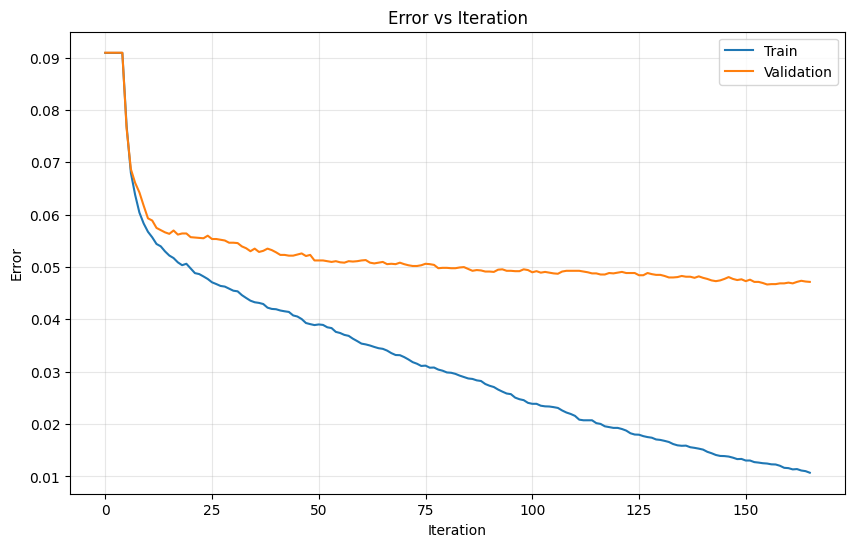

Threshold: 0.10 - MCC Score: 0.6377
Threshold: 0.15 - MCC Score: 0.6766
Threshold: 0.20 - MCC Score: 0.6945
Threshold: 0.25 - MCC Score: 0.7054
Threshold: 0.30 - MCC Score: 0.7058
Threshold: 0.35 - MCC Score: 0.7099
Threshold: 0.40 - MCC Score: 0.7051
Threshold: 0.45 - MCC Score: 0.7029
Threshold: 0.50 - MCC Score: 0.6907
Threshold: 0.55 - MCC Score: 0.6774
Threshold: 0.60 - MCC Score: 0.6612
Threshold: 0.65 - MCC Score: 0.6439
Threshold: 0.70 - MCC Score: 0.6294
Threshold: 0.75 - MCC Score: 0.6021
Threshold: 0.80 - MCC Score: 0.5630
Threshold: 0.85 - MCC Score: 0.5086

Best threshold: 0.35 with MCC Score: 0.7099
Confusion Matrix:
[[12548   328]
 [  347   941]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     12876
           1       0.74      0.73      0.74      1288

    accuracy                           0.95     14164
   macro avg       0.86      0.85      0.85     14164
weighted avg       0.95      0.95 

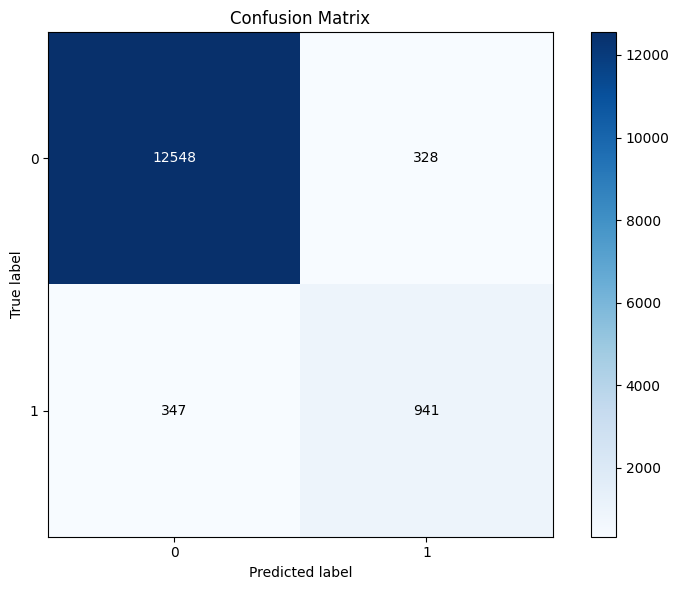

✅ Training pipeline completed successfully!


In [21]:
# Initialize configuration
config = Config(
    data_dir="/kaggle/input/gammafest-celan/gammafest25",  # Update with correct path
    neg_pos_ratio=10,
    prediction_threshold=0.35
)

# Initialize pipeline
pipeline = Pipeline(config)

# Run training pipeline
if __name__ == '__main__':
    try:
        model = pipeline.train_pipeline()
        print("✅ Training pipeline completed successfully!")
    except Exception as e:
        print(f"❌ Error in training pipeline: {str(e)}")

In [29]:
# Run prediction pipeline
if __name__ == '__main__':
    try:
        submission = pipeline.predict_pipeline()
        print("✅ Prediction pipeline completed successfully!")
    except Exception as e:
        print(f"❌ Error in prediction pipeline: {str(e)}")

KeyboardInterrupt: 